In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder,PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

In [2]:
# Reinitialize scaler and PCA
scaler = StandardScaler()
pca = PCA(n_components=7) 

In [3]:
#data location
column_definition_path="./Data/column_definitions.xlsx"
airline_data_path="./Data/DS_airline_delay_causes.csv"

#import data to dataframes
flight_data_df=pd.read_csv(airline_data_path)
column_definition_df=pd.read_excel(column_definition_path)

In [4]:
#displaying first five rows
print("Displaying first five rows of Flight data")
flight_data_df.head()

Displaying first five rows of Flight data


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,Unnamed: 21
0,2009,11,AS,Alaska Airlines Inc.,DCA,"Washington, DC: Ronald Reagan Washington National",88.0,11.0,1.99,0.00,...,0.00,0.0,0.0,266.0,65.0,0.0,201.0,0.0,0.0,NaN
1,2009,11,AS,Alaska Airlines Inc.,DEN,"Denver, CO: Denver International",123.0,5.0,3.47,0.00,...,0.00,0.0,0.0,81.0,57.0,0.0,24.0,0.0,0.0,NaN
2,2009,11,AS,Alaska Airlines Inc.,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",66.0,6.0,1.28,0.69,...,0.00,0.0,0.0,176.0,64.0,11.0,101.0,0.0,0.0,NaN
3,2009,11,AS,Alaska Airlines Inc.,EWR,"Newark, NJ: Newark Liberty International",59.0,10.0,0.24,0.00,...,0.56,0.0,0.0,553.0,8.0,0.0,526.0,0.0,19.0,NaN
4,2009,11,AS,Alaska Airlines Inc.,HNL,"Honolulu, HI: Daniel K Inouye International",85.0,18.0,1.34,1.46,...,0.00,0.0,0.0,547.0,85.0,89.0,373.0,0.0,0.0,NaN


In [5]:
#getting basic info of the flight data 
flight_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73282 entries, 0 to 73281
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 73282 non-null  int64  
 1    month               73282 non-null  int64  
 2   carrier              73282 non-null  object 
 3   carrier_name         73282 non-null  object 
 4   airport              73282 non-null  object 
 5   airport_name         73282 non-null  object 
 6   arr_flights          73240 non-null  float64
 7   arr_del15            73211 non-null  float64
 8   carrier_ct           73240 non-null  float64
 9    weather_ct          73240 non-null  float64
 10  nas_ct               73240 non-null  float64
 11  security_ct          73240 non-null  float64
 12  late_aircraft_ct     73240 non-null  float64
 13  arr_cancelled        73240 non-null  float64
 14  arr_diverted         73240 non-null  float64
 15   arr_delay           73240 non-null 

In [6]:
# Count missing values per column
missing_values = flight_data_df.isnull().sum()

print("Missing values in the dataset:")
print(missing_values)

Missing values in the dataset:
year                       0
 month                     0
carrier                    0
carrier_name               0
airport                    0
airport_name               0
arr_flights               42
arr_del15                 71
carrier_ct                42
 weather_ct               42
nas_ct                    42
security_ct               42
late_aircraft_ct          42
arr_cancelled             42
arr_diverted              42
 arr_delay                42
 carrier_delay            42
weather_delay             42
nas_delay                 42
security_delay            42
late_aircraft_delay       42
Unnamed: 21            73282
dtype: int64


In [7]:
## DATASET CLEANUP ###

#Removing Unnamed: 21 feature
flight_data_df.drop('Unnamed: 21', axis=1, inplace=True)

#Removing Samples with missing values
flight_data_df.dropna(inplace=True)

#we observe space between some features, we remove them
flight_data_df.rename(columns=lambda x: x.lstrip() if x.startswith(' ') else x, inplace=True)

#check for duplicate data samples
duplicates = flight_data_df.duplicated().sum()
#print(f"Number of duplicate rows: {duplicates}\n")

#dropping duplicate rows
flight_data_df.drop_duplicates(inplace=True)

# Replace negative values in nas_ct and nas_delay with 0
flight_data_df["nas_ct"] = flight_data_df["nas_ct"].apply(lambda x: max(x, 0))
flight_data_df["nas_delay"] = flight_data_df["nas_delay"].apply(lambda x: max(x, 0))

# As airport code and airport denote the same value, we drop it. We do similar to carrier and carrier_code
flight_data_df.drop('carrier_name', axis=1, inplace=True)
flight_data_df.drop('airport_name', axis=1, inplace=True)

In [8]:
#getting current df.info
flight_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73211 entries, 0 to 73281
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 73211 non-null  int64  
 1   month                73211 non-null  int64  
 2   carrier              73211 non-null  object 
 3   airport              73211 non-null  object 
 4   arr_flights          73211 non-null  float64
 5   arr_del15            73211 non-null  float64
 6   carrier_ct           73211 non-null  float64
 7   weather_ct           73211 non-null  float64
 8   nas_ct               73211 non-null  float64
 9   security_ct          73211 non-null  float64
 10  late_aircraft_ct     73211 non-null  float64
 11  arr_cancelled        73211 non-null  float64
 12  arr_diverted         73211 non-null  float64
 13  arr_delay            73211 non-null  float64
 14  carrier_delay        73211 non-null  float64
 15  weather_delay        73211 non-null  floa

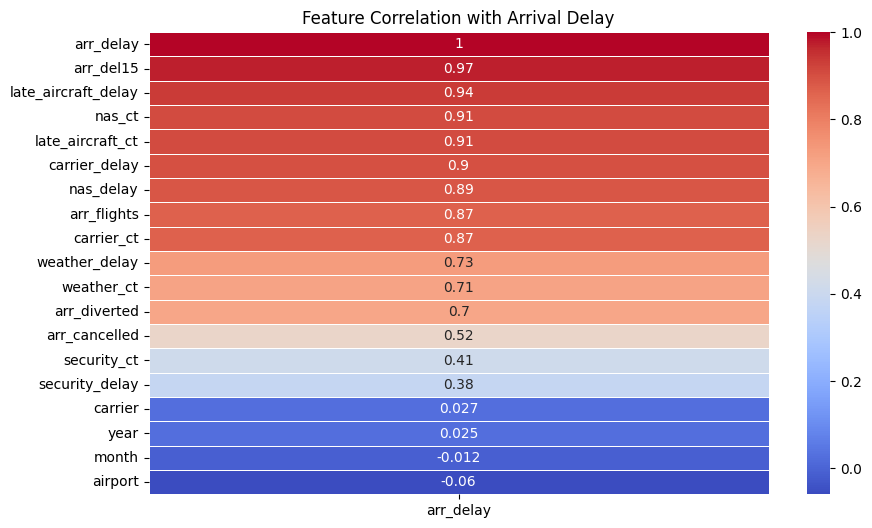

In [9]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['carrier', 'airport']

for col in categorical_cols:
    le = LabelEncoder()
    flight_data_df[col] = le.fit_transform(flight_data_df[col])
    label_encoders[col] = le

# Compute correlation matrix
corr_matrix = flight_data_df.corr()

# Plot heatmap of correlations with `arr_delay`
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix[['arr_delay']].sort_values(by='arr_delay', ascending=False), 
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation with Arrival Delay")
plt.show()

In [10]:
# Define features and target variable
features = ['carrier', 'airport', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 
            'nas_ct', 'security_ct', 'late_aircraft_ct', 'carrier_delay', 'weather_delay', 
            'nas_delay', 'security_delay', 'late_aircraft_delay']

# Scale features
features_scaled = scaler.fit_transform(flight_data_df[features])

# Apply PCA
features_pca = pca.fit_transform(features_scaled)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.60020532 0.10023479 0.07213405 0.07111175 0.06180083 0.04201825
 0.0197118 ]


In [12]:
y = flight_data_df['arr_delay']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features_pca, y, test_size=0.2, random_state=42)

# Create polynomial features (degree 2 for better complexity-performance tradeoff)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Measure execution time
start_time = time.time()

# Train a polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make predictions
y_pred = model.predict(X_test_poly)

# End time
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [13]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Square Error (MSE): {mse}")
print(f"R2 Sscore: {r2}")
print(f"Execution Time: {execution_time} seconds")

Mean Absolute Error (MAE): 1170.8346617837258
Mean Square Error (MSE): 7654798.004339997
R2 Sscore: 0.9853036943265382
Execution Time: 0.11858558654785156 seconds


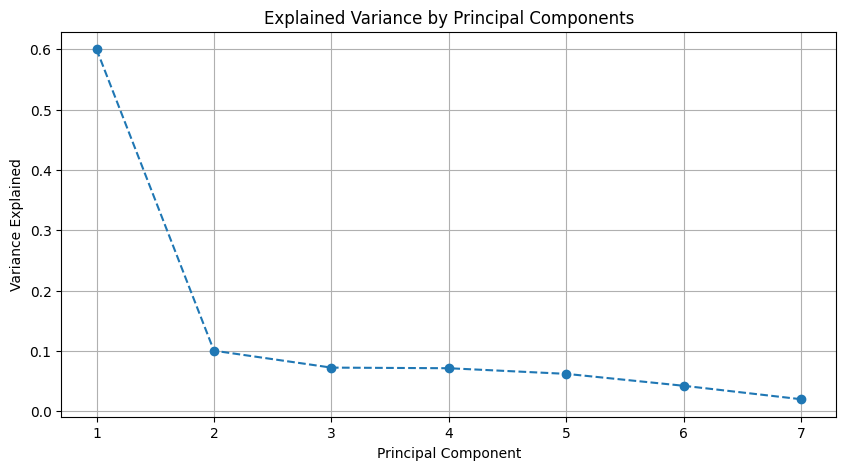

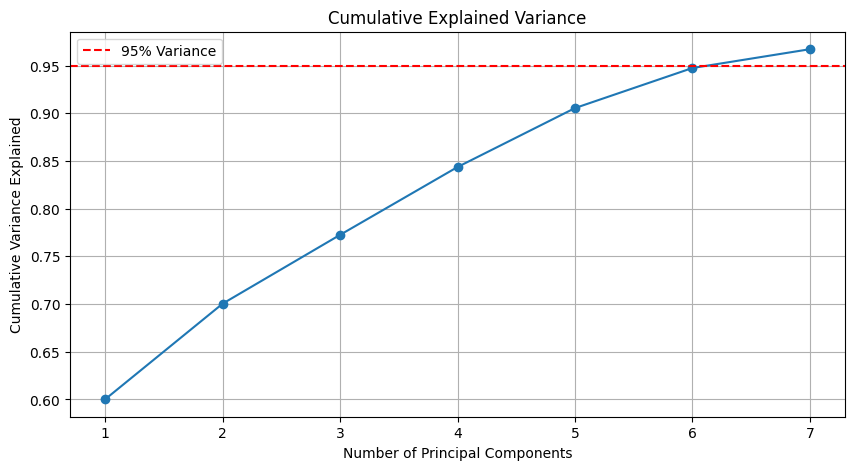

In [14]:
# Plot variance explained by each principal component
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

# Cumulative variance explained
cumulative_variance = explained_variance.cumsum()

# Plot cumulative variance explained
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.grid()
plt.show()

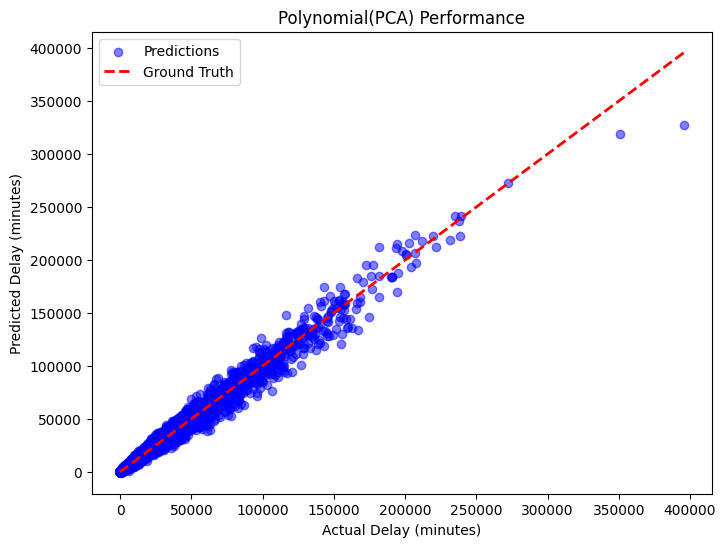

In [15]:
# Scatter plot: Actual vs Predicted Delays
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions", color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', linewidth=2, label="Ground Truth")
plt.xlabel("Actual Delay (minutes)")
plt.ylabel("Predicted Delay (minutes)")
plt.title("Polynomial(PCA) Performance")
plt.legend()
plt.show()